In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt

from utils import dt2int
from collections import namedtuple

from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

In [2]:
# better plots
sns.set()

# better progress
tqdm.pandas()

In [3]:
# custom data types
Action = namedtuple("Action", ["CHO", "insulin"])

In [4]:
SAMPLE_TIME = 1 # min
EAT_RATE = 5 # g/min CHO

_last_action = Action(CHO=0, insulin=0)
_last_foodtaken = 0
_is_eating = False
_planned_meal = 0

def ode(t, x, in_t, in_CHO, in_insulin, params):
    global _last_action, _is_eating, _planned_meal, _last_Qsto, _last_foodtaken

    # get current action
    t_mask = np.abs(in_t - t).argmin()
    action = Action(CHO=in_CHO[t_mask], insulin=in_insulin[t_mask])

    meal = action.CHO
    _planned_meal += meal
    if _planned_meal > 0:
        to_eat = min(EAT_RATE, _planned_meal)
        _planned_meal -= to_eat
        _planned_meal = max(0, _planned_meal)
    else:
        to_eat = 0

    action = action._replace(CHO=to_eat)

    # detect eating and update last digestion amount
    if action.CHO > 0 and _last_action.CHO <= 0:
        _last_Qsto = x[0] + x[1]
        _last_foodtaken = 0
        _is_eating = True

    if _is_eating:
        _last_foodtaken += action.CHO # g

    # detect eating ended
    if action.CHO <= 0 and _last_action.CHO > 0:
        _is_eating = False

    # update last action
    _last_action = action

    # dynamics
    dxdt = np.zeros(13)
    d = action.CHO * 1000  # g -> mg
    insulin = action.insulin * 6000 / params.BW  # U/min -> pmol/kg/min
    basal = params.u2ss * params.BW / 6000  # U/min

    # glucose in the stomach
    qsto = x[0] + x[1]
    # NOTE: Dbar is in unit mg, hence last_foodtaken needs to be converted
    # from mg to g. See https://github.com/jxx123/simglucose/issues/41 for
    # details.
    Dbar = _last_Qsto + _last_foodtaken * 1000  # unit: mg

    # Stomach solid
    dxdt[0] = -params.kmax * x[0] + d

    if Dbar > 0:
        aa = 5 / 2 / (1 - params.b) / Dbar
        cc = 5 / 2 / params.d / Dbar
        kgut = params.kmin + (params.kmax - params.kmin) / 2 * (
            np.tanh(aa * (qsto - params.b * Dbar)) -
            np.tanh(cc * (qsto - params.d * Dbar)) + 2)
    else:
        kgut = params.kmax

    # stomach liquid
    dxdt[1] = params.kmax * x[0] - x[1] * kgut

    # intestine
    dxdt[2] = kgut * x[1] - params.kabs * x[2]

    # Rate of appearance
    Rat = params.f * params.kabs * x[2] / params.BW
    # Glucose Production
    EGPt = params.kp1 - params.kp2 * x[3] - params.kp3 * x[8]
    # Glucose Utilization
    Uiit = params.Fsnc

    # renal excretion
    if x[3] > params.ke2:
        Et = params.ke1 * (x[3] - params.ke2)
    else:
        Et = 0

    # glucose kinetics
    # plus dextrose IV injection input u[2] if needed
    dxdt[3] = max(EGPt, 0) + Rat - Uiit - Et - \
        params.k1 * x[3] + params.k2 * x[4]
    dxdt[3] = (x[3] >= 0) * dxdt[3]

    Vmt = params.Vm0 + params.Vmx * x[6]
    Kmt = params.Km0
    Uidt = Vmt * x[4] / (Kmt + x[4])
    dxdt[4] = -Uidt + params.k1 * x[3] - params.k2 * x[4]
    dxdt[4] = (x[4] >= 0) * dxdt[4]

    # insulin kinetics
    dxdt[5] = -(params.m2 + params.m4) * x[5] + params.m1 * x[9] + params.ka1 * \
        x[10] + params.ka2 * x[11]  # plus insulin IV injection u[3] if needed
    It = x[5] / params.Vi
    dxdt[5] = (x[5] >= 0) * dxdt[5]

    # insulin action on glucose utilization
    dxdt[6] = -params.p2u * x[6] + params.p2u * (It - params.Ib)

    # insulin action on production
    dxdt[7] = -params.ki * (x[7] - It)

    dxdt[8] = -params.ki * (x[8] - x[7])

    # insulin in the liver (pmol/kg)
    dxdt[9] = -(params.m1 + params.m30) * x[9] + params.m2 * x[5]
    dxdt[9] = (x[9] >= 0) * dxdt[9]

    # subcutaneous insulin kinetics
    dxdt[10] = insulin - (params.ka1 + params.kd) * x[10]
    dxdt[10] = (x[10] >= 0) * dxdt[10]

    dxdt[11] = params.kd * x[10] - params.ka2 * x[11]
    dxdt[11] = (x[11] >= 0) * dxdt[11]

    # subcutaneous glucose
    dxdt[12] = (-params.ksc * x[12] + params.ksc * x[3])
    dxdt[12] = (x[12] >= 0) * dxdt[12]

    # if action.insulin > basal:
    #     print('t = {}, injecting insulin: {}'.format(t, action.insulin))

    return dxdt

# Load and preprocess data

In [5]:
data = pd.read_csv("results/adult#001.csv")

# destructure data
data_t = data["Time"].map(lambda d: dt2int(d, fmt="%Y-%m-%d %H:%M:%S.%f")).to_numpy()
data_CGM = data["CGM"].to_numpy()
data_CHO = data["CHO"].to_numpy()
data_insulin = data["insulin"].to_numpy()

# normalize time
data_t -= data_t[0]

# clean CHO and insulin
data_CHO = np.nan_to_num(data_CHO, 0.0)
data_insulin = np.nan_to_num(data_insulin, 0.0)

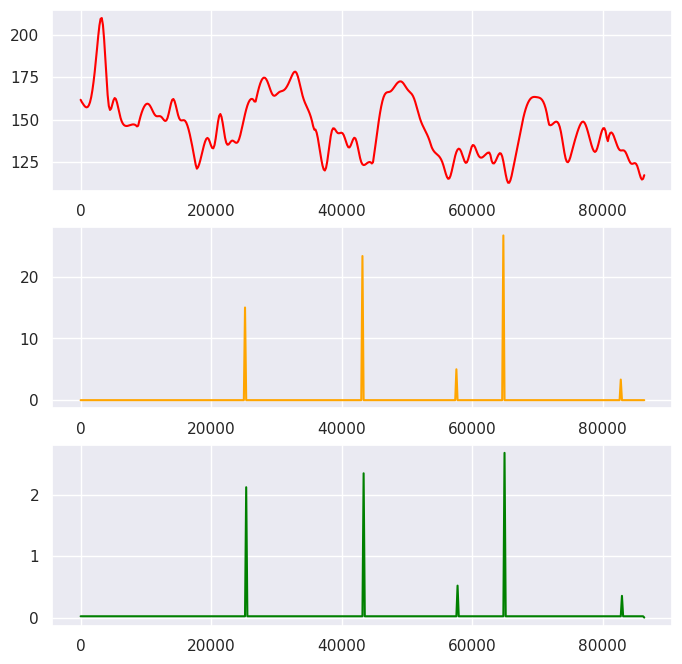

In [6]:
# visualize data
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(data_t, data_CGM, label="CGM", color="red")
plt.subplot(3, 1, 2)
plt.plot(data_t, data_CHO, label="CHO", color="orange")
plt.subplot(3, 1, 3)
plt.plot(data_t, data_insulin, label="insulin", color="green")
plt.show()

In [7]:
# load parameters
orig_params = pd.read_csv("../simglucose/simglucose/params/vpatient_params.csv")
params = orig_params.loc[orig_params["Name"] == "adult#001"].squeeze()

In [8]:
# timespan
t_span = (data_t[0], data_t[-1])
t_eval = data_t

In [9]:
# initial conditions
u0 = params.iloc[2:15].to_numpy()
_last_Qsto = u0[0] + u0[1]

In [10]:
sol = solve_ivp(ode, t_span, u0, t_eval=t_eval, args=(data_t, data_CHO, data_insulin, params))

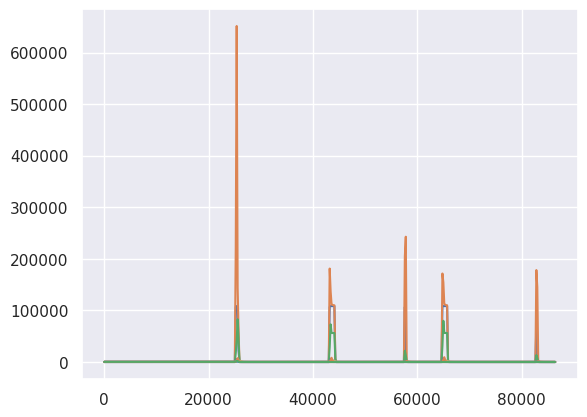

In [11]:
plt.plot(sol.t, sol.y.T)